In [93]:
from Bio import SeqIO
from Bio.SeqUtils import GC
import click
import gzip
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns

In [47]:
# Matrix
data = np.load("./matrix2d.ReMap+UniBind.sparse.npz")
for i in data.files:
    matrix2d = data[i]
matrix2d

array([[nan,  0., nan, ..., nan, nan, nan],
       [ 0.,  0., nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [48]:
# Regions
with gzip.open("./regions_idx.pickle.gz", "rb") as f:
    regions_dict = pickle.load(f)
regions_df = pd.Series(regions_dict).sort_values()
regions_df

chr1  10095     10295             0
      16145     16345             1
      56175     56375             2
      90115     90315             3
      96495     96695             4
                             ...   
chrY  56878155  56878355    1817913
      56878675  56878875    1817914
      56880415  56880615    1817915
      56881535  56881735    1817916
      56881775  56881975    1817917
Length: 1817918, dtype: int64

In [49]:
# TFs
with gzip.open("./tfs_idx.pickle.gz", "rb") as f:
    tfs_dict = pickle.load(f)
tfs_df = pd.Series(tfs_dict).sort_values()
tfs_df

AHR         0
AR          1
ARID3A      2
ARNT        3
ATF1        4
         ... 
ZNF143    158
ZNF24     159
ZNF263    160
ZNF384    161
ZNF740    162
Length: 163, dtype: int64

In [50]:
# Effective CTCF regions
effective_regions = pd.Series(
    matrix2d[:, tfs_df["CTCF"]], index=regions_df.values
).dropna()
effective_regions

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
          ... 
1817912    0.0
1817913    0.0
1817914    0.0
1817915    0.0
1817916    0.0
Length: 1656242, dtype: float64

In [51]:
# Positive regions
positive_regions = effective_regions[effective_regions == 1].index
positive_regions

Int64Index([      7,      16,      22,      49,     107,     112,     124,
                144,     175,     179,
            ...
            1817571, 1817618, 1817621, 1817700, 1817706, 1817711, 1817721,
            1817723, 1817732, 1817832],
           dtype='int64', length=78984)

In [52]:
# Negative regions
negative_regions = effective_regions[effective_regions == 0].index
negative_regions

Int64Index([      0,       1,       2,       3,       4,       5,       6,
                  8,       9,      10,
            ...
            1817907, 1817908, 1817909, 1817910, 1817911, 1817912, 1817913,
            1817914, 1817915, 1817916],
           dtype='int64', length=1577258)

In [78]:
# Initialize positive sequences
positive_sequences = {}
for i in range(101):
    positive_sequences.setdefault(i, [])
positive_sequences

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: [],
 69: [],
 70: [],
 71: [],
 72: [],
 73: [],
 74: [],
 75: [],
 76: [],
 77: [],
 78: [],
 79: [],
 80: [],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [],
 87: [],
 88: [],
 89: [],
 90: [],
 91: [],
 92: [],
 93: [],
 94: [],
 95: [],
 96: [],
 97: [],
 98: [],
 99: [],
 100: []}

In [79]:
# Initialize positive sequences
negative_sequences = {}
for i in range(101):
    negative_sequences.setdefault(i, [])
negative_sequences

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [],
 21: [],
 22: [],
 23: [],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: [],
 30: [],
 31: [],
 32: [],
 33: [],
 34: [],
 35: [],
 36: [],
 37: [],
 38: [],
 39: [],
 40: [],
 41: [],
 42: [],
 43: [],
 44: [],
 45: [],
 46: [],
 47: [],
 48: [],
 49: [],
 50: [],
 51: [],
 52: [],
 53: [],
 54: [],
 55: [],
 56: [],
 57: [],
 58: [],
 59: [],
 60: [],
 61: [],
 62: [],
 63: [],
 64: [],
 65: [],
 66: [],
 67: [],
 68: [],
 69: [],
 70: [],
 71: [],
 72: [],
 73: [],
 74: [],
 75: [],
 76: [],
 77: [],
 78: [],
 79: [],
 80: [],
 81: [],
 82: [],
 83: [],
 84: [],
 85: [],
 86: [],
 87: [],
 88: [],
 89: [],
 90: [],
 91: [],
 92: [],
 93: [],
 94: [],
 95: [],
 96: [],
 97: [],
 98: [],
 99: [],
 100: []}

In [80]:
# FASTA sequences
sequences = {}
with gzip.open("./sequences.200bp.fa.gz", "rt") as handle:
    for seq_record in SeqIO.parse(handle, "fasta"):
        region, coordinates = seq_record.id.split("::")
        region = int(region)
        sequence = str(seq_record.seq) 
        if region in positive_regions:
            positive_sequences[round(GC(sequence))].append(region)
            sequences.setdefault(region, sequence)
        elif region in negative_regions:
            negative_sequences[round(GC(sequence))].append(region)
            sequences.setdefault(region, sequence)
len(sequences)

1656242

In [81]:
positive_sequences

{0: [],
 1: [],
 2: [],
 3: [],
 4: [],
 5: [],
 6: [],
 7: [],
 8: [],
 9: [],
 10: [],
 11: [],
 12: [],
 13: [],
 14: [],
 15: [],
 16: [],
 17: [],
 18: [],
 19: [],
 20: [361734],
 21: [],
 22: [464035, 501244, 885370, 1624461],
 23: [203429, 1266064, 1564540, 1591124],
 24: [181696,
  198305,
  308229,
  379825,
  464635,
  502944,
  825464,
  881874,
  1063182,
  1120862,
  1212601,
  1227278,
  1230451,
  1336133,
  1465373,
  1468577,
  1508743,
  1551447,
  1636251,
  1718069,
  1730289,
  1796717],
 25: [136644,
  356290,
  393857,
  395450,
  400536,
  747509,
  917546,
  957862,
  1193937,
  1206545,
  1243264,
  1404925,
  1547775,
  1632117],
 26: [13054,
  43086,
  52636,
  64260,
  66084,
  66397,
  77287,
  77484,
  113247,
  113279,
  124535,
  125663,
  180475,
  181352,
  220619,
  275236,
  314132,
  343311,
  358985,
  364173,
  366563,
  394378,
  435915,
  442427,
  455109,
  457646,
  464754,
  465210,
  491678,
  560853,
  592073,
  627543,
  681094,
  837358

In [82]:
# Downsampling
sampled = {}
random_seed = 123
for i in range(101):
    random.Random(random_seed).shuffle(positive_sequences[i])
    random.Random(random_seed).shuffle(negative_sequences[i])
    min_length = min(
        [len(positive_sequences[i]), len(negative_sequences[i])]
    )
    for j in range(min_length):
        sampled.setdefault("positives", set())
        sampled["positives"].add(positive_sequences[i][j])
        sampled.setdefault("negatives", set())
        sampled["negatives"].add(negative_sequences[i][j])

In [83]:
print(len(sampled["positives"]), len(sampled["negatives"]))

78984 78984


In [89]:
# Save sequences
with gzip.open("./pos_seqs.fa.gz", "wb") as f:
    for positive in sorted(sampled["positives"]):
        string = ">%s\n%s\n" % (positive, sequences[positive])
        f.write(string.encode("utf-8"))

In [90]:
with gzip.open("./neg_seqs.fa.gz", "wb") as f:
    for negative in sorted(sampled["negatives"]):
        string = ">%s\n%s\n" % (negative, sequences[negative])
        f.write(string.encode("utf-8"))

In [91]:
# Sanity check
gc_positives = []
with gzip.open("./pos_seqs.fa.gz", "rt") as handle:
    for seq_record in SeqIO.parse(handle, "fasta"):
        gc_positives.append(GC(str(seq_record.seq)))
gc_positives = np.array(gc_positives)
gc_positives

array([57. , 55. , 53. , ..., 46. , 41.5, 54. ])

In [92]:
gc_negatives = []
with gzip.open("./neg_seqs.fa.gz", "rt") as handle:
    for seq_record in SeqIO.parse(handle, "fasta"):
        gc_negatives.append(GC(str(seq_record.seq)))
gc_negatives = np.array(gc_negatives)
gc_negatives

array([55.5, 63.5, 50. , ..., 38. , 38. , 47. ])

In [97]:
data = []
for i in gc_positives:
    data.append(["positives", i])
for i in gc_negatives:
    data.append(["negatives", i])
df = pd.DataFrame(data, columns=["Sequence", "%GC"])
df

,Sequence,%GC
0,positives,57.0
1,positives,55.0
2,positives,53.0
3,positives,64.0
4,positives,47.5
...,...,...
157963,negatives,45.5
157964,negatives,39.5
157965,negatives,38.0
157966,negatives,38.0


[(0.0, 100.0)]

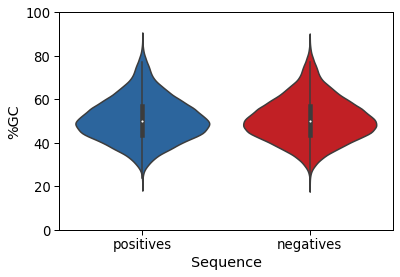

In [108]:
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 1.5})
sns.set_palette(sns.color_palette(["#1965B0", "#DC050C"]))
g = sns.violinplot(x="Sequence", y="%GC", data=df)
g.set(ylim=(0, 100))